In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.layers import Layer # Import the Layer class
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:


def generate_synthetic_data(n_samples=100, n_genes=5, n_methylation=5, treatment_effect=0.3, random_seed=42):
    """
    Generate a synthetic dataset for training a VAE, with gene expression, methylation, and treatment status.

    Parameters:
    - n_samples: Total number of samples (half untreated, half treated)
    - n_genes: Number of gene expression features
    - n_methylation: Number of methylation features
    - treatment_effect: Magnitude of the treatment effect on gene expression and methylation
    - random_seed: Seed for reproducibility

    Returns:
    - df: A DataFrame containing gene expression, methylation, and treatment status columns
    """
    np.random.seed(random_seed)

    # Number of untreated and treated samples (split equally)
    n_untreated = n_samples // 2
    n_treated = n_samples - n_untreated

    # Generate synthetic gene expression and methylation data
    gene_expression_untreated = np.random.normal(loc=0.5, scale=0.1, size=(n_untreated, n_genes))
    gene_expression_treated = np.random.normal(loc=0.5 + treatment_effect, scale=0.1, size=(n_treated, n_genes))

    methylation_untreated = np.random.normal(loc=0.5, scale=0.1, size=(n_untreated, n_methylation))
    methylation_treated = np.random.normal(loc=0.5 - treatment_effect, scale=0.1, size=(n_treated, n_methylation))

    # Stack untreated and treated data
    gene_expression_data = np.vstack([gene_expression_untreated, gene_expression_treated])
    methylation_data = np.vstack([methylation_untreated, methylation_treated])

    # Generate binary treatment status (0 for untreated, 1 for treated)
    treatment_status = np.array([0] * n_untreated + [1] * n_treated)

    # Combine gene expression, methylation, and treatment status into a single DataFrame
    df = pd.DataFrame(np.hstack([gene_expression_data, methylation_data]),
                      columns=[f'GeneExp_{i+1}' for i in range(n_genes)] +
                              [f'Meth_{i+1}' for i in range(n_methylation)])

    df['TreatmentStatus'] = treatment_status

    return df



In [ ]:
# Example usage:
synthetic_df = generate_synthetic_data(n_samples=200, n_genes=1000, n_methylation=1000)
(synthetic_df.tail())


,GeneExp_1,GeneExp_2,GeneExp_3,GeneExp_4,GeneExp_5,GeneExp_6,GeneExp_7,GeneExp_8,GeneExp_9,GeneExp_10,...,Meth_992,Meth_993,Meth_994,Meth_995,Meth_996,Meth_997,Meth_998,Meth_999,Meth_1000,TreatmentStatus
195,0.782564,0.728667,0.801878,1.009186,0.812814,0.714539,0.650938,0.743077,0.786303,0.651362,...,0.098245,0.058221,0.215507,0.080290,0.211916,0.089784,0.192669,0.075979,0.305248,1
196,1.022679,0.685382,0.870131,0.880805,0.878301,1.041902,0.815074,0.805667,0.870737,1.081348,...,0.365257,0.345540,0.195069,0.248080,0.251647,0.196322,0.036220,0.226013,0.328215,1
197,0.684092,1.021685,0.563645,0.949101,0.644966,0.991512,0.897312,0.753820,0.764103,0.815090,...,0.217092,0.331671,0.430136,0.070640,0.146840,0.053558,0.187206,0.115891,0.199451,1
198,0.729946,0.819170,0.810057,0.876758,0.710643,0.704214,0.982943,0.858543,0.869065,0.698399,...,0.308215,0.141478,0.324049,0.100836,0.200856,0.260670,0.064123,0.028782,0.145161,1
199,0.804107,0.827473,0.756085,0.681671,0.927513,0.823416,0.830918,0.846181,0.800689,0.636175,...,0.223081,0.217995,0.304188,0.148185,0.144554,-0.031638,0.283156,0.246253,0.186264,1


In [ ]:
# Example DataFrame structure:
# - Columns: ['GeneExpression1', 'GeneExpression2', ..., 'Methylation1', 'Methylation2', ..., 'TreatmentStatus']
# - Rows: Samples, first half untreated, second half treated.

# Step 1: Data Preprocessing and Normalization
def preprocess_data(df):
    # Separate the features (gene expression, methylation) and treatment status
    treatment_status = df['TreatmentStatus'].values
    features = df.drop('TreatmentStatus', axis=1).values

    # Normalize the gene expression and methylation data
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Return normalized features and treatment status
    return features_scaled, treatment_status

In [ ]:
prepedData, treatmentStatus =  preprocess_data(synthetic_df)

In [ ]:
prepedData.shape

(200, 2000)

In [ ]:
treatmentStatus.shape

(200,)

In [ ]:
class VariationalAutoencoder(tf.keras.Model):
    def __init__(self, input_dim, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = models.Sequential([
            layers.InputLayer(input_shape=(input_dim,)),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(latent_dim + latent_dim)  # mean and logvar (latent_dim for each)
        ])

        # Decoder
        self.decoder = models.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(32, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(input_dim, activation='sigmoid')  # Reconstruct the input
        ])

    def reparameterize(self, mean, logvar):
        # Reparameterization trick: z = mean + eps * exp(logvar/2)
        eps = tf.random.normal(shape=tf.shape(mean))
        return mean + eps * tf.exp(logvar * 0.5)

    def call(self, x):
        # Encode input to mean and logvar
        z_mean_logvar = self.encoder(x)
        z_mean, z_logvar = tf.split(z_mean_logvar, num_or_size_splits=2, axis=1)

        # Reparameterization trick
        z = self.reparameterize(z_mean, z_logvar)

        # Decode the latent variable back to input space
        reconstructed = self.decoder(z)

        return reconstructed, z_mean, z_logvar


In [ ]:
# Step 3: Loss Functions
def compute_loss(model, x):
    # Forward pass
    reconstructed, z_mean, z_logvar = model(x)

    # Reconstruction loss (Mean Squared Error)
    mse_loss = tf.reduce_mean(tf.keras.losses.mse(x, reconstructed))

    # KL divergence loss (to make the learned distribution close to the standard normal distribution)
    kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar), axis=1))

    # Total VAE loss
    return mse_loss + kl_loss

# Step 4: Training Function
def train_vae(model, dataset, epochs=50, batch_size=32):
    optimizer = tf.keras.optimizers.Adam()
    lossOut = []

    for epoch in range(epochs):
        for batch_data in dataset.batch(batch_size):
            with tf.GradientTape() as tape:
                loss = compute_loss(model, batch_data)


            # Compute gradients and apply them
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        print(f"Epoch {epoch + 1}, Loss: {loss.numpy()}")
        lossOut.append(loss.numpy())

    return lossOut


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(prepedData)

In [ ]:
# Step 6: Initialize and train the VAE
latent_dim = 3
vae = VariationalAutoencoder(input_dim=prepedData.shape[1], latent_dim=latent_dim)
history = train_vae(vae, dataset, epochs=50, batch_size=32)


Epoch 1, Loss: 14.190691947937012
Epoch 2, Loss: 7.468587875366211
Epoch 3, Loss: 6.878623008728027
Epoch 4, Loss: 4.96292781829834
Epoch 5, Loss: 5.937361717224121
Epoch 6, Loss: 5.01999568939209
Epoch 7, Loss: 2.4412574768066406
Epoch 8, Loss: 1.3554385900497437
Epoch 9, Loss: 1.2115089893341064
Epoch 10, Loss: 1.0887856483459473
Epoch 11, Loss: 1.0542845726013184
Epoch 12, Loss: 1.038096308708191
Epoch 13, Loss: 1.031994342803955
Epoch 14, Loss: 1.013700246810913
Epoch 15, Loss: 1.0367504358291626
Epoch 16, Loss: 1.0609506368637085
Epoch 17, Loss: 1.0396124124526978
Epoch 18, Loss: 1.07828688621521
Epoch 19, Loss: 1.0362004041671753
Epoch 20, Loss: 1.047435998916626
Epoch 21, Loss: 1.0293490886688232
Epoch 22, Loss: 1.023669958114624
Epoch 23, Loss: 0.9958958029747009
Epoch 24, Loss: 0.9911382794380188
Epoch 25, Loss: 1.0010299682617188
Epoch 26, Loss: 1.042554259300232
Epoch 27, Loss: 1.3302894830703735
Epoch 28, Loss: 1.4765621423721313
Epoch 29, Loss: 1.2950677871704102
Epoch 30,

In [ ]:
len(history)

50

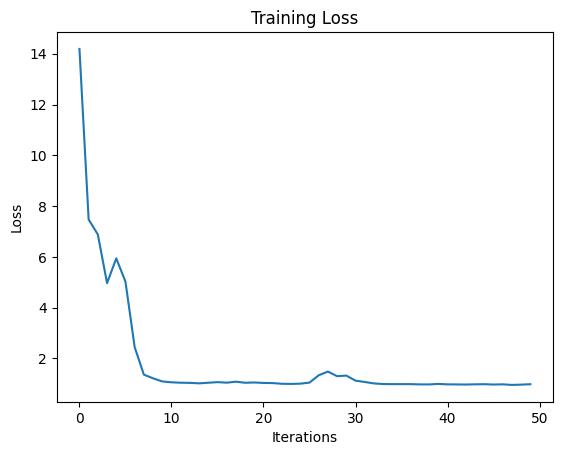

In [ ]:
# prompt: geenrate a simple line plot for history

import matplotlib.pyplot as plt

plt.plot(history)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()


In [ ]:
vae.summary()

Model: "variational_autoencoder_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)            │ (None, 6)                   │         266,662 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_7 (Sequential)            │ (None, 2000)                │         268,560 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 535,222 (2.04 MB)

 Trainable params: 535,222 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
vae.encoder.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                     │ (None, 128)                 │         256,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 266,662 (1.02 MB)

 Trainable params: 266,662 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
vae.encoder.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                     │ (None, 128)                 │         256,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 266,662 (1.02 MB)

 Trainable params: 266,662 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

# Reconstruct Data

In [ ]:
def make_predictions(vae, new_data):
    """
    Use the trained VAE to make predictions (reconstructions) on new input data.

    Parameters:
    - vae: The trained VAE model
    - new_data: New input data (normalized) for which to generate predictions.

    Returns:
    - reconstructed_data: Reconstructed data from the decoder.
    - latent_space: The latent representations (z_mean) from the encoder.
    """
    # Step 1: Encode the new data to get latent representation (z_mean)
    z_mean_logvar = vae.encoder.predict(new_data)
    z_mean, _ = np.split(z_mean_logvar, 2, axis=1)  # Split z_mean and z_logvar

    # Step 2: Decode the latent representation back to reconstruct the input data
    reconstructed_data = vae.decoder.predict(z_mean)

    return reconstructed_data, z_mean



In [ ]:
# Example usage:
# Assuming `vae` is the trained VAE model and `new_data_scaled` is the new input data
reconstructed_data, latent_space = make_predictions(vae, prepedData)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


In [ ]:
first_column_reconstructed = reconstructed_data[:, 1]
first_column_prepedData = prepedData[:, 1]

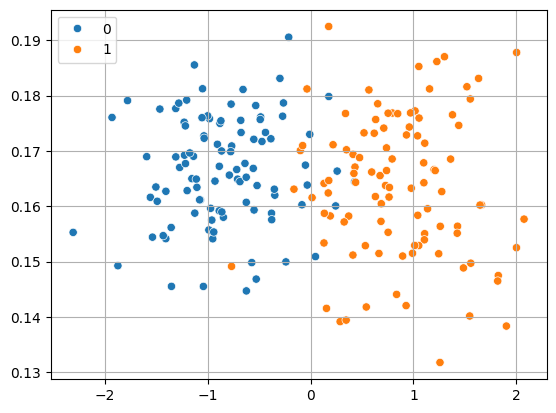

In [ ]:
sns.scatterplot(x=first_column_prepedData, y=first_column_reconstructed, hue=treatmentStatus)
plt.grid(True)
plt.show()

In [ ]:


def visualize_latent_space(vae, data, treatment_status, use_tsne=True):
    """
    Visualize the latent space of a trained VAE using t-SNE or PCA.

    Parameters:
    - vae: The trained VAE model
    - data: Normalized data (gene expression + methylation) used to train the VAE
    - treatment_status: Binary treatment status (0 for untreated, 1 for treated)
    - use_tsne: If True, use t-SNE; otherwise, use PCA for dimensionality reduction

    Returns:
    - A scatter plot of the latent space with color coding for treated vs untreated
    """

    # Step 1: Encode the data to get the latent mean (z_mean)
    z_mean_logvar = vae.encoder.predict(data)
    z_mean, _ = np.split(z_mean_logvar, 2, axis=1)  # Use z_mean, ignore logvar

    # Step 2: Reduce the dimensions using t-SNE or PCA
    if use_tsne:
        print("Applying t-SNE for dimensionality reduction...")
        latent_2d = TSNE(n_components=2, random_state=42).fit_transform(z_mean)
    else:
        print("Applying PCA for dimensionality reduction...")
        latent_2d = PCA(n_components=2).fit_transform(z_mean)

    # Step 3: Create a scatter plot of the 2D latent space
    plt.figure(figsize=(8, 6))
    plt.scatter(latent_2d[treatment_status == 0, 0], latent_2d[treatment_status == 0, 1],
                c='blue', label='Untreated', alpha=0.7)
    plt.scatter(latent_2d[treatment_status == 1, 0], latent_2d[treatment_status == 1, 1],
                c='red', label='Treated', alpha=0.7)

    plt.title('Latent Space Visualization')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.legend()
    #plt.grid(True)
    plt.show()



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Applying t-SNE for dimensionality reduction...


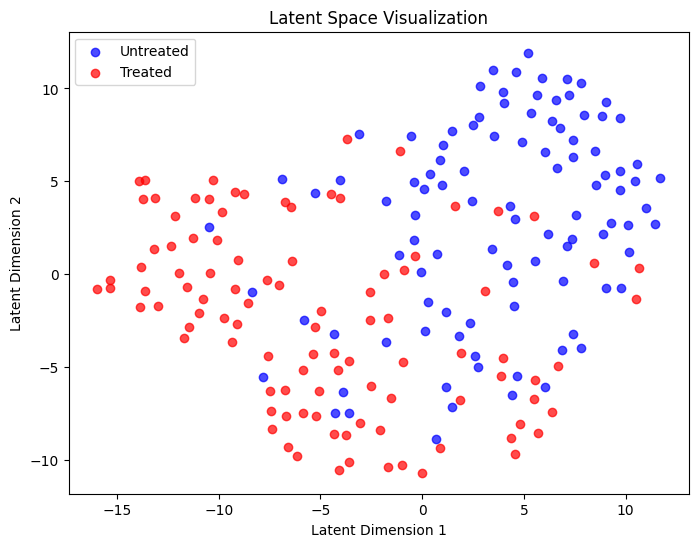

In [ ]:
# Example usage:
# Assuming `vae` is the trained VAE model and `features_scaled` contains normalized data
# `treatment_status` is a binary array where 0 = untreated, 1 = treated
visualize_latent_space(vae, prepedData, treatmentStatus, use_tsne=True)
